In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
import matplotlib.ticker as mtick

%matplotlib inline

bEdges = np.load('BandEdge.npy').item()
DefTot = np.load('DefectTotalEnergy.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrections.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
SurfaceCalc = np.load('SurfCalc.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()


def setChemPot(cond, delta={}):
    mu = {}
    mu['Zn'] = cond[0] + ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    mu['Ge'] = cond[1] + ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    mu['N'] = cond[2] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
            continue
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        elif len(ChemPot[ref][1]) == 2:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

def getPOSCARdiff(defect):
    default = {'Zn':32, 'Ge':32, 'N':64}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            pass
    for i in levels:
        # add functionality to get defect levels: 
        # if str(int(i)-1) in levels:
        #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['ZnGeN2_VB']
            
        if i in FreyCorr[defect]:
            levels[i] += FreyCorr[defect][i]
        pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ZnGeN2_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print def_i_l
    return pDefect

from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')

    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)


In [42]:
def PlotForm2(Defects1, Condition1, Defects2, Condition2, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4)) 
    ax = plt.subplot(121)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

    
    ax = plt.subplot(122)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_yticklabels([], fontsize=16)
    ax.yaxis.set_ticks_position('both')
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    fig.text(0.523, -0.02, 'Fermi Energy (eV)', ha='center', fontsize=16)


Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/3, FormEnth('Ge3N4')/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

In [43]:
Znpoor2

[-0.8397674041666658, -0.2550897458333334, 0]

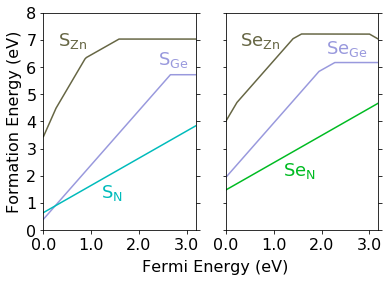

In [44]:
PlotForm2({'S_Ge':[2.4,6.1], 'S_Zn':[0.3,6.8], 'S_N':[1.2,1.2]},Gepoor,
         {'Se_Ge':[2.1,6.5], 'Se_Zn':[0.3,6.8], 'Se_N':[1.2,2.0]},Gepoor,ylimits=[0,8])

plt.savefig('SSe.eps', 
            bbox_inches='tight', format='eps', dpi=300)
plt.savefig('SSe.png', bbox_inches='tight', format='png', dpi=300)


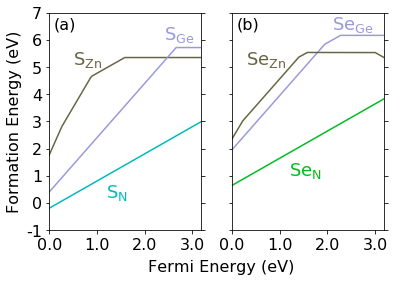

In [45]:
PlotForm2({'S_Ge':[2.4,6.0], 'S_Zn':[0.5,5.1], 'S_N':[1.2,0.2]},Znpoor2,
         {'Se_Ge':[2.1,6.4], 'Se_Zn':[0.3,5.1], 'Se_N':[1.2,1.0]},Znpoor2,ylimits=[-1,7])
plt.text(0.1, 6.4, '(b)', fontsize=16)
plt.text(-3.73, 6.4, '(a)', fontsize=16)

plt.savefig('SSe.eps', 
            bbox_inches='tight', format='eps', dpi=300)
plt.savefig('SSe.png', bbox_inches='tight', format='png', dpi=300)


In [46]:
def PlotForm2(Defects1, Condition1, Defects2, Condition2, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,4)) 
    ax = plt.subplot(121)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('P', fontsize=16)

    
    ax = plt.subplot(122)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')
    ax.set_yticklabels([], fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('As', fontsize=16)
    fig.text(0.523, -0.02, 'Fermi Energy (eV)', ha='center', fontsize=16)


Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/3, FormEnth('Ge3N4')/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

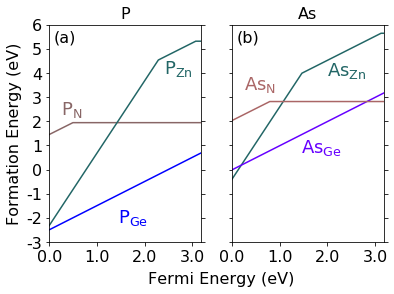

In [47]:
PlotForm2({'P_Ge':[1.45,-2.2], 'P_Zn':[2.4,4.0], 'P_N':[0.25,2.3]},Npoor,
         {'As_Ge':[1.45,0.7], 'As_Zn':[2.0,3.9], 'As_N':[0.25,3.3]},Npoor,ylimits=[-3,6])

plt.text(0.1, 5.3, '(b)', fontsize=16)
plt.text(-3.73, 5.3, '(a)', fontsize=16)


plt.savefig('PAs.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('PAs.eps', bbox_inches='tight', format='eps', dpi=300)


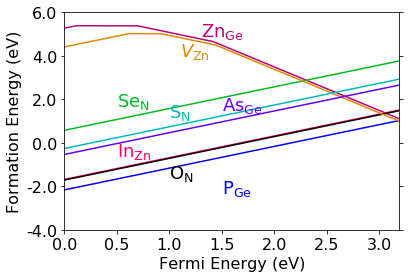

In [48]:
PlotForm({'S_N':[1.0,1.2], 'Se_N':[0.5,1.7],
          'P_Ge':[1.5, -2.3], 'As_Ge':[1.5,1.5],
          'In_Zn':[0.5,-0.6], 
          'O_N':[1.0,-1.63],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},Znpoor1,ylimits=[-4,6])

plt.savefig('ntype.eps', bbox_inches='tight', format='eps', dpi=300)


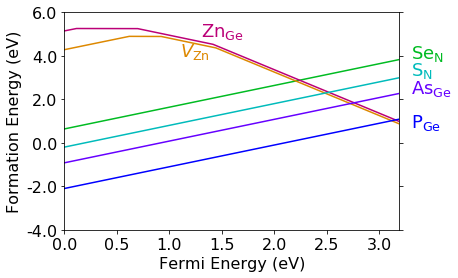

In [49]:
colors = np.load('LineColors.npy').item()

PlotForm({'S_N':[3.3,3.1], 
          'Se_N':[3.3,3.9],
          'P_Ge':[3.3, 0.7], 
          'As_Ge':[3.3,2.3], 
          #'In_Zn':[3.3,1.5], 
          #'O_N':[3.3,1.5],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},Znpoor2,ylimits=[-4,6])

plt.savefig('ntype.eps', bbox_inches='tight', format='eps', dpi=300)
plt.savefig('ntype.png', bbox_inches='tight', format='png', dpi=300)


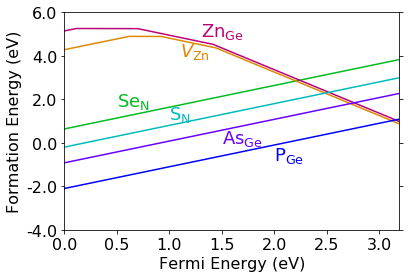

In [50]:
colors = np.load('LineColors.npy').item()

PlotForm({'Se_N':[0.5,1.7],
          'S_N':[1.0,1.1],  
          'As_Ge':[1.5,-0.0],
          'P_Ge':[2.0, -.8],
          #'In_Zn':[3.3,1.5], 
          #'O_N':[3.3,1.5],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},Znpoor2,ylimits=[-4,6])

plt.savefig('ntype.eps', bbox_inches='tight', format='eps', dpi=300)
plt.savefig('ntype.png', bbox_inches='tight', format='png', dpi=300)


array([-0.35611127, -0.54742857, -0.09565865])

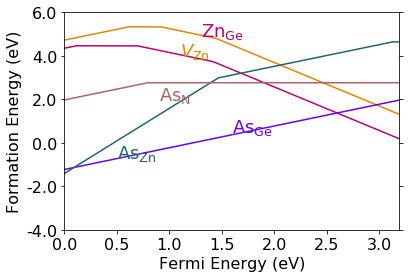

In [51]:
PlotForm({'As_Zn':[],'As_N':[],
          'As_Ge':[1.6,0.5],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},[-0.40,-0.61,0],ylimits=[-4,6])
np.array(Gepoor)/2 + np.array(Znpoor1)/2
#plt.savefig('ntypeO.eps', bbox_inches='tight', format='eps', dpi=300)
#plt.savefig('ntypeO.png', bbox_inches='tight', format='png', dpi=300)


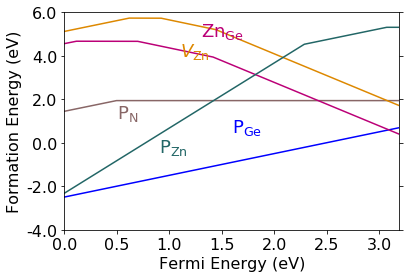

In [52]:
PlotForm({'P_Zn':[],'P_N':[],
          'P_Ge':[1.6,0.5],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},Npoor,ylimits=[-4,6])

#plt.savefig('ntypeO.eps', bbox_inches='tight', format='eps', dpi=300)
#plt.savefig('ntypeO.png', bbox_inches='tight', format='png', dpi=300)


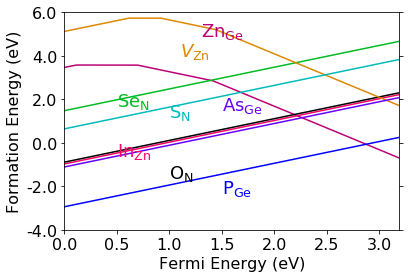

In [53]:
PlotForm({'S_N':[1.0,1.2], 'Se_N':[0.5,1.7],
          'P_Ge':[1.5, -2.3], 'As_Ge':[1.5,1.5],
          'In_Zn':[0.5,-0.6], 
          'O_N':[1.0,-1.63],
          'Zn_Ge':[1.3,4.9],'V_Zn':[1.1,4]},Gepoor,ylimits=[-4,6])

plt.savefig('ntype.eps', bbox_inches='tight', format='eps', dpi=300)


In [54]:
def Figure1(Defects1,comp1, Defects2,comp2, Defects3,comp3, Defects4,comp4, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(12,4)) 
    ax = plt.subplot(141)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0][0],ylimits[0][1])
        if comp1:
            plt.plot([comp1, comp1],ylimits,'-.',color='#666666')
            ax.text(comp1+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)

    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('S', fontsize=16)

    
    ax = plt.subplot(142)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0][0],ylimits[0][1])
        if comp2:
            plt.plot([comp2, comp2],ylimits,'-.',color='#666666')
            ax.text(comp2+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('Se', fontsize=16)

    
    ax = plt.subplot(143)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects3:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects3[i]:
            ax.text(Defects3[i][0],Defects3[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[1][0],ylimits[1][1])
        if comp3:
            plt.plot([comp3, comp3],ylimits,'-.',color='#666666')
            ax.text(comp3+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
    plt.title('P', fontsize=16)
    
    ax = plt.subplot(144)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects4:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects4[i]:
            ax.text(Defects4[i][0],Defects4[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[1][0],ylimits[1][1])
        if comp4:
            plt.plot([comp4, comp4],ylimits,'-.',color='#666666')
            ax.text(comp4+0.05,-1.9,r'$\epsilon_{F,comp}$',fontdict={'size':14},color='black')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.title('As', fontsize=16)
    fig.text(0.523, -0.02, 'Fermi Energy (eV)', ha='center', fontsize=16)
    plt.tight_layout()

Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/3, FormEnth('Ge3N4')/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

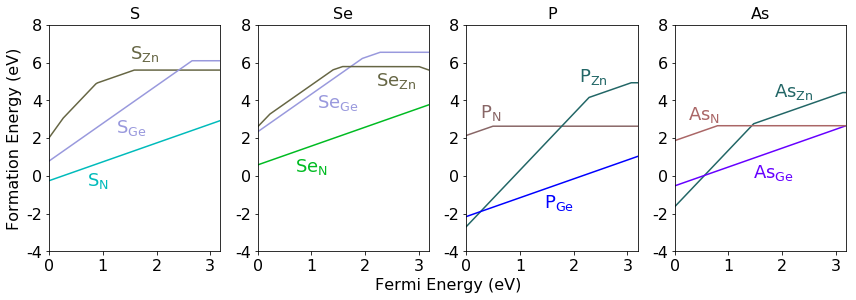

In [19]:
colors = np.load('LineColors.npy').item()

Figure1({'S_Ge':[1.25,2.3], 'S_Zn':[1.5,6.2], 'S_N':[0.7,-0.5]}, 0,
        {'Se_Ge':[1.1,3.6], 'Se_Zn':[2.2,4.8], 'Se_N':[0.7,0.2]}, 0,
        {'P_Ge':[1.45,-1.7], 'P_Zn':[2.1,5.0], 'P_N':[0.25,3.1]}, 0, 
        {'As_Ge':[1.45,-0.1], 'As_Zn':[1.85,4.2], 'As_N':[0.25,3.0]}, 0, 
          
         Znpoor1,ylimits=[[-4,8],[-4,8]])

plt.savefig('ntype_f1.png', bbox_inches='tight', format='png', dpi=400)
plt.savefig('ntype_f1.eps', bbox_inches='tight', format='eps', dpi=400)


In [20]:
def contourdef(defect, charge='',add_mu={}):
    defLoc = DefTot[defect]
    n_mu = getPOSCARdiff(defect)
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.01, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
    for ele in DefTot[defect][1]:
        if ele not in mu:
            lrefs = {}
            lmu = {}
            for ref in ChemPot:
                if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
                    continue
                if ele in ChemPot[ref][1]:
                    lrefs[ref] = ref
                    lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
            if len(lrefs) > 1:
                mumat3 = np.dstack((lmu[i] for i in lmu))
                mu[ele] = np.amin(mumat3, axis=2)
            else:
                mu[ele] = lmu.values()[0]
            
    print n_mu
    a = sum(n_mu[j] * mu[j] for j in n_mu)
    z = DefTot[defect][0][charge] + FreyCorr[defect][charge] - E0 - sum(n_mu[j] * mu[j] for j in n_mu) + bEdges['ZnGeN2_CB']*int(charge)
    npoor = z[-1,-1]
    gepoor = z[-1,1]
    print npoor, gepoor
    N2conv = muGe-muGe0 +0.02 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 -0.02 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    z = z * N2conv * Ge3N4conv + z[55][55]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))
    print(z[55][55])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.pcolor(muZn - muZn0, muGe-muGe0, z)
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.00])
    ax.set_ylim([-1.095, -0.00])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    
    ax.text(-0.25,-0.15,u'N-poor',fontdict={'size':18},color='#000000')
    ax.text(-0.27,-1.17,u'Ge-poor',fontdict={'size':18},color='#000000')

    plt.scatter(-0.84,-.255, s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0, -0,s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0, FormEnth('ZnGeN2') -0.01,s=80,color='orange',clip_on=False,zorder=3)

    ax.text(-1.1, -0.32,u'Zn-poor',fontdict={'size':18},color='black')

    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    
    
    ax.text(0.18,0.1,text_def[defect] +' (eV)',fontdict={'size':18},color='#000000')

    # Now adding the colorbar
    cbaxes = fig.add_axes([1.05, 0.06, 0.05, 0.73]) 
    cb = plt.colorbar(cmap, cax = cbaxes)  
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    


    
    #plt.colorbar(cmap)
    #plt.savefig('Contour.eps', bbox_inches='tight', format='eps', dpi=400)
    plt.savefig('Contour.png', bbox_inches='tight', format='png', dpi=400)

    plt.show() 

-2.3719226
-6.450436785000001
-9.670895155
{'Zn': 1, 'Ge': -1, 'N': 0}
0.4001133250000013 1.500113325000001
0.4001133250000013


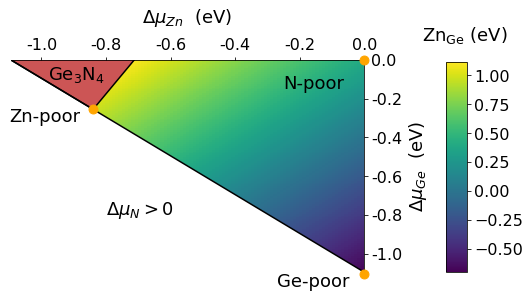

In [21]:
contourdef('Zn_Ge',charge='-2')


-2.3719226
-6.450436785000001
-9.670895155
{'P': 1, 'Zn': 0, 'Ge': -1, 'N': 0}
0.719872860000093 1.3408120483334214
0.7974787150000866


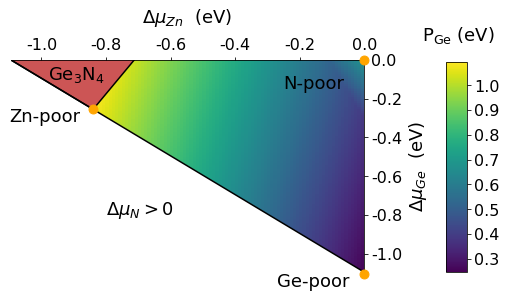

In [22]:
contourdef('P_Ge',charge='1')


In [23]:
a = -0.71
b = -0.0
c = FormEnth('ZnGeN2') - a - b
cond = [a, b, c]

print -5.62523686 #ele
print (-75.20117589 / 4 - (-2.5438452/2 + cond[0] + -10.70087357/2+cond[1]))/2 #ZnGeAs2
print (-130.90751686 / 8 - (-2.5438452/2 * 3 + cond[0]*3))/2 #Zn3As2
print (-133.266014 / 12 - (-10.70087357/2 + cond[1])) #GeAs

-5.62523686
-5.73396729375
-5.20883590375
-5.75506438167


-2.3719226
-6.450436785000001
-9.670895155
{'Zn': 0, 'As': 1, 'Ge': -1, 'N': 0}
3.1980719287500623 2.674300406666731
1.9744728850000612


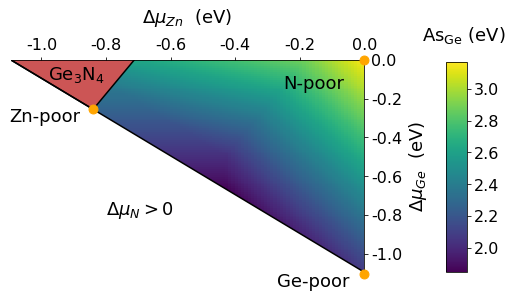

In [24]:
contourdef('As_Ge',charge='1')


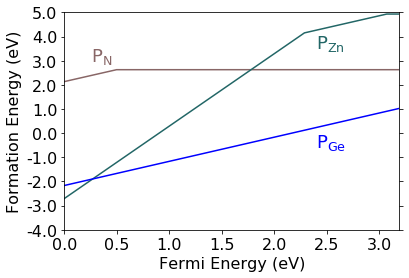

In [25]:
PlotForm({'P_Ge':[2.4,-0.6], 'P_Zn':[2.4,3.5], 'P_N':[0.25,3.0]},Znpoor1,ylimits=[-4,5])
plt.savefig('P_Ge_temp.png', bbox_inches='tight', format='png', dpi=300)


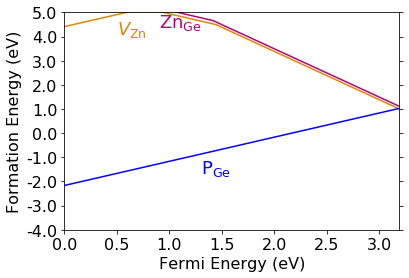

In [26]:
PlotForm({'P_Ge':[], 'Zn_Ge':[], 'V_Zn':[]},Znpoor1,ylimits=[-4,5])


In [27]:
def contourdefmult(defects, Ncolors, action='intersect', charge=[],add_mu={}):
    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.0, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']

    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]

    
    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if ele in ChemPot[ref][1]:
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    print Totmu
    if action == 'intersect':
        diff = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]]))
        diff2 = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[2]][j] * mu[j] for j in Totmu[defects[2]]))
        diff += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnGeN2_VB']*int(charge[0])) - (DefTot[defects[1]][0][charge[1]]+FreyCorr[defects[1]][charge[1]] + bEdges['ZnGeN2_VB']*int(charge[1]))
        diff2 += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnGeN2_VB']*int(charge[0])) - (DefTot[defects[2]][0][charge[2]]+FreyCorr[defects[2]][charge[2]] + bEdges['ZnGeN2_VB']*int(charge[2]))
        z = diff / (float(charge[1]) - float(charge[0]))
        z2 = diff2 / (float(charge[2]) - float(charge[0]))
        zall = np.dstack((z, z2))
        print zall.shape
        zf = np.amin(zall, axis=2)
    N2conv = muGe-muGe0 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    zf = zf * N2conv * Ge3N4conv + zf[55][55]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))
    print(zf[55][55])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muGe-muGe0, zf-bEdges['ZnGeN2_CB']+bEdges['ZnGeN2_VB'], Ncolors)
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.01])
    ax.set_ylim([-1.095, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    ax.text(-0.5,-0.3,u'ZnGeN$_2$',fontdict={'size':22},color='#000000')
    
    plt.scatter(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.01, -0.01,s=80,color='blue',clip_on=False,zorder=3)
    ax.text(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.02,-0.15,u'Zn-poor',fontdict={'size':18},color='black')


    cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    cb.set_ticks([-0.31, 0.02])
    #cb.set_label(label=r'E$_{F,comp}$', size=22)
    
    ax.text(0.4,-0.6,r'$E_F-E_C$ (eV)',fontdict={'size':18},color='#000000')

    
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('ZnGeN2.png', bbox_inches='tight', format='png', dpi=400)
    #plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
    plt.show() 

-2.3719226
-6.450436785000001
-9.670895155
{'V_Zn': {'Zn': -1, 'Ge': 0, 'N': 0}, 'Zn_Ge': {'Zn': 1, 'Ge': -1, 'N': 0}, 'P_Ge': {'P': 1, 'Zn': 0, 'Ge': -1, 'N': 0}}
(110, 110, 2)
3.0567018699999493


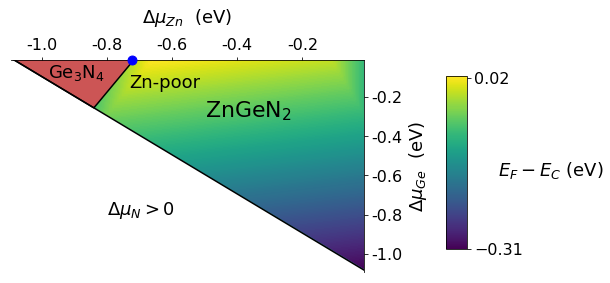

In [28]:
ab = contourdefmult(['P_Ge','V_Zn', 'Zn_Ge'],200,'intersect',charge=['1','-2','-2'])


In [29]:
me = 0.21442691171479733 * 9.10938e-31
kb = 1.38064852e-23
h = 6.62607004e-34


Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6

In [30]:
def contour_n(defects, charge=[],add_mu={}):
    T = 1000
    me = 0.21442691171479733 * 9.10938e-31
    kb = 1.38064852e-23
    h = 6.62607004e-34
    q = 1.6e-19
    Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
    Eg = bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB']
    Ef = np.arange(2.8000,3.2000,0.0001)
    

    Elec = Nc(T)*np.exp((Ef-Eg)*q/kb/T)
    V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)

    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.01, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']

    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
        
    EF = 0 * muZn

    
    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if ele in ChemPot[ref][1]:
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    print Totmu
    
    Eform = [-(sum(Totmu[defects[p]][j] * mu[j] for j in Totmu[defects[p]])) + (DefTot[defects[p]][0][charge[p]]-DefTot['default'][0]['0']+FreyCorr[defects[p]][charge[p]] + bEdges['ZnGeN2_VB']*int(charge[p])) for p in range(len(charge))]
    for s in range(len(x)):
        for t in range(len(y)):
            bcde = [sum(int(charge[i]) * V * np.exp(-(Eform[i][s][t]+int(charge[i])*r)*q/kb/T) for i in range(len(charge))) for r in Ef] - Elec
            EF[s][t] = 28000 + np.argmin(abs(bcde))
            #print [EF[s][t], s, t]

    nelec = Nc(T)*np.exp((EF/10000.0-Eg)*q/kb/T)
    print nelec

    N2conv = muGe-muGe0 + 0.02 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 - 0.02 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    nelec = nelec * N2conv * Ge3N4conv + nelec[55][55]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))
    print(nelec[55][55])
    
    return nelec
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()
    n = 50
    A = np.tile(np.logspace(17,20,n),(n,1))
    levels = 10.**np.arange(17,20,4)
    cmap = plt.contourf(muZn - muZn0, muGe-muGe0, nelec, Ncolors, locator=ticker.LogLocator())
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.01])
    ax.set_ylim([-1.095, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    ax.text(-0.5,-0.3,u'ZnGeN$_2$',fontdict={'size':22},color='#000000')
    
    plt.scatter(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.01, -0.01,s=80,color='blue',clip_on=False,zorder=3)
    ax.text(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.02,-0.15,u'Zn-poor',fontdict={'size':18},color='black')


    cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    cb.set_ticks([-0.31, 0.02])
    #cb.set_label(label=r'E$_{F,comp}$', size=22)
    
    ax.text(0.4,-0.6,r'$E_F-E_C$ (eV)',fontdict={'size':18},color='#000000')

    
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('ZnGeN2.png', bbox_inches='tight', format='png', dpi=400)
    #plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
    plt.show() 
#ab = contour_n(['P_Ge','V_Zn', 'Zn_Ge'],200,'intersect',charge=['1','-2','-2'])


AttributeError: 'NoneType' object has no attribute 'min'

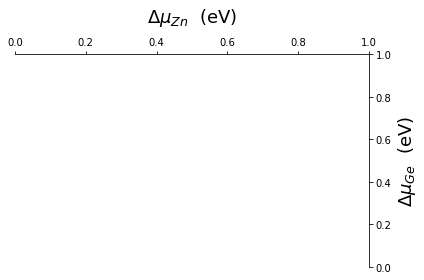

In [31]:
#ab = contour_n(['P_Ge','V_Zn', 'Zn_Ge'],charge=['1','-2','-2'])

import matplotlib.colors as colors

muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
x = np.arange(-1.10, 0.01, 1e-2) 
muZn = x + muZn0
y = np.arange(-1.10, 0.01, 1e-2) 
muGe = y + muGe0
muZn, muGe = np.meshgrid(muZn, muGe)

fig, ax = plt.subplots()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
ax.xaxis.labelpad = 15

fig.tight_layout()

levels = 10.**np.arange(17,20,4)

cmap = plt.pcolor(muZn - muZn0, muGe-muGe0, ab,
                  norm=colors.LogNorm(vmin=ab.min(), vmax=ab.max()))
ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
ax.set_xlim([-1.095, -0.00])
ax.set_ylim([-1.095, -0.00])
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
plt.plot(y, FormEnth('ZnGeN2')-x,'k')
plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
ax.text(-0.5,-0.3,u'ZnGeN$_2$',fontdict={'size':22},color='#000000')

plt.scatter(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.01, -0.01,s=80,color='blue',clip_on=False,zorder=3)
ax.text(FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2.0 -0.02,-0.15,u'Zn-poor',fontdict={'size':18},color='black')


cbaxes = fig.add_axes([1.05, 0.14, 0.05, 0.6]) 
cb = plt.colorbar(cmap, cax = cbaxes)
#cb.set_ticks([1e17, 1e18, 1e19])
#cb.set_label(label=r'E$_{F,comp}$', size=22)

ax.text(0.4,-0.6,r'$E_F-E_C$ (eV)',fontdict={'size':18},color='#000000')


cb.ax.tick_params(labelsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('ZnGeN2.png', bbox_inches='tight', format='png', dpi=400)
#plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
plt.show() 

In [ ]:
np.max(ab)

In [ ]:
Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
Elec = Nc(T)*np.exp((Ef-Eg)*q/kb/T)

Eg = bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB']

V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)
Ef = np.arange(0,Eg,0.0001)

EF = 0 * muZn





Eform = [-(sum(Totmu[defects[p]][j] * mu[j] for j in Totmu[defects[p]])) + (DefTot[defects[p]][0][charge[p]]-DefTot['default'][0]['0']+FreyCorr[defects[p]][charge[p]] + bEdges['ZnGeN2_VB']*int(charge[p])) for p in range(len(charge))]
for s in range(len(x)):
    for t in range(len(y)):
        bcde = lambda T: sum(charge[i] * V * np.exp(-Eform[i][s][t]*q/kb/T) for i in range(len(charge))) - Elec(T)
        EF[s][t] = np.argmin(abs(bcde(T)))

        
nelec = Nc(T)*np.exp((EF-Eg)*q/kb/T)
        
        
EF_low = kb*300/q*np.log(nelec/Nc(300))
        

diff2 = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[2]][j] * mu[j] for j in Totmu[defects[2]]))
diff += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnGeN2_VB']*int(charge[0])) - (DefTot[defects[1]][0][charge[1]]+FreyCorr[defects[1]][charge[1]] + bEdges['ZnGeN2_VB']*int(charge[1]))
diff2 += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnGeN2_VB']*int(charge[0])) - (DefTot[defects[2]][0][charge[2]]+FreyCorr[defects[2]][charge[2]] + bEdges['ZnGeN2_VB']*int(charge[2]))
z = diff / (float(charge[1]) - float(charge[0]))
z2 = diff2 / (float(charge[2]) - float(charge[0]))
zall = np.dstack((z, z2))
print zall.shape
zf = np.amin(zall, axis=2)

In [ ]:
b = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Al_Ge[a]+0.1)/8.61733e-5/1050.0)
c = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Al_Zn[a]+0.1)/8.61733e-5/1050.0)
d = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-H_i[a]/8.61733e-5/1050.0)
b - c - d




In [ ]:
DefTot['default'][0]['0']

In [ ]:
me = 0.21442691171479733 * 9.10938e-31
kb = 1.38064852e-23
h = 6.62607004e-34
q = 1.6e-19

Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
Eg = bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB']

V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)
Ef = np.arange(0,Eg,0.0001)


Elec = lambda T: Nc(T)*np.exp((Ef-Eg)*q/kb/T)


Eform = 
bcde = lambda T: sum(charge[i] * V * np.exp(-Eform[i]*q/kb/T) for i in range(len(charge))) - Elec(T)


EF = lambda T: np.argmin(abs(bcde(T)))
nelec = lambda T: Nc(T)*np.exp((EF-Eg)*q/kb/T)

EF_low = lambda T: kb*300/q*np.log(nelec(T)/Nc(300))

In [ ]:
np.log(10)

In [ ]:
Elec(300)

In [ ]:
DefTot['V_Zn'][0]

In [ ]:
defects = ['P_Ge','V_Zn', 'Zn_Ge']
charge = ['1','-2','-2']

In [ ]:
#ab = contour_n(['P_Ge','V_Zn', 'Zn_Ge'],charge=['1','-2','-2'])

import matplotlib.colors as colors

muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
x = np.arange(-1.10, 0.01, 1e-2) 
muZn = x + muZn0
y = np.arange(-1.10, 0.01, 2e-2) 
muGe = y + muGe0
muZn, muGe = np.meshgrid(muZn, muGe)


In [ ]:
f = lambda x: [x, x**2, x**3]

In [ ]:
np.shape(f(muZn))

In [ ]:
def contour_n2(defects, charge=[],add_mu={}):
    T = 1100
    me = 0.21442691171479733 * 9.10938e-31
    kb = 1.38064852e-23
    h = 6.62607004e-34
    q = 1.6e-19
    Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
    Eg = bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB']
    Ef = np.arange(0.000,3.200,0.001)
    

    Elec = Nc(T)*np.exp((Ef-Eg)*q/kb/T)
    V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)

    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.01, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']

    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
        
    EF = 0 * muZn

    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
                        continue
                    if ele in ChemPot[ref][1]:
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    
    Eform = [-(sum(Totmu[defects[p]][j] * mu[j] for j in Totmu[defects[p]])) + (DefTot[defects[p]][0][charge[p]]-DefTot['default'][0]['0']+FreyCorr[defects[p]][charge[p]] + bEdges['ZnGeN2_VB']*int(charge[p])) for p in range(len(charge))]

    defs = np.array([sum(int(charge[i]) * V * np.exp(-(Eform[i]+int(charge[i])*r)*q/kb/T) for i in range(len(charge))) for r in Ef])
    bcde = np.swapaxes(defs,0,2)- np.array(Elec)
    EF = 0 + np.argmin(abs(np.swapaxes(bcde,0,2)), axis=0)
    nelec = Nc(T)*np.exp((EF/1000.0-Eg)*q/kb/T)
    
    N2conv = muGe-muGe0 + 0.02 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 -0.02 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    nelec = nelec * N2conv * Ge3N4conv + nelec[50][50]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))

    return nelec
ab = contour_n2(['P_Ge','V_Zn', 'Zn_Ge'],charge=['1','-2','-2'])

import matplotlib.colors as colors

muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
x = np.arange(-1.10, 0.01, 1e-2) 
muZn = x + muZn0
y = np.arange(-1.10, 0.01, 1e-2) 
muGe = y + muGe0
muZn, muGe = np.meshgrid(muZn, muGe)

fig, ax = plt.subplots()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
ax.xaxis.labelpad = 15

fig.tight_layout()

levels = 10.**np.arange(17,20,4)

cmap = plt.pcolor(muZn - muZn0, muGe-muGe0, ab,
                  norm=colors.LogNorm(vmin=ab.min(), vmax=ab.max()))
ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
ax.set_xlim([-1.095, -0.00])
ax.set_ylim([-1.095, -0.00])
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
plt.plot(y, FormEnth('ZnGeN2')-x,'k')
plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')


ax.text(-0.25,-0.15,u'N-poor',fontdict={'size':18},color='#000000')
ax.text(-0.27,-1.17,u'Ge-poor',fontdict={'size':18},color='#000000')

plt.scatter(-0.84,-.255, s=80,color='orange',clip_on=False,zorder=3)
plt.scatter(-0, -0,s=80,color='orange',clip_on=False,zorder=3)
plt.scatter(-0, FormEnth('ZnGeN2') -0.01,s=80,color='orange',clip_on=False,zorder=3)

ax.text(-1.1, -0.32,u'Zn-poor',fontdict={'size':18},color='black')


cbaxes = fig.add_axes([1.05, 0.06, 0.05, 0.73]) 
cb = plt.colorbar(cmap, cax = cbaxes)
#cb.set_ticks([1e17, 1e18, 1e19])
#cb.set_label(label=r'E$_{F,comp}$', size=22)

ax.text(0.18,0.1,r'$n$ ($\rm cm^{-3}$)',fontdict={'size':18},color='#000000')


cb.ax.tick_params(labelsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('PGe.png', bbox_inches='tight', format='png', dpi=400)
#plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
plt.show() 

In [ ]:
cmap = plt.pcolor(muZn - muZn0, muGe-muGe0, ab,
                  norm=colors.LogNorm(vmin=ab.min(), vmax=ab.max()))


In [ ]:
def contour_n2(defects, charge=[],add_mu={}):
    T = 1100
    me = 0.21442691171479733 * 9.10938e-31
    kb = 1.38064852e-23
    h = 6.62607004e-34
    q = 1.6e-19
    Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
    Eg = bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB']
    Ef = np.arange(0.000,3.200,0.001)
    

    Elec = Nc(T)*np.exp((Ef-Eg)*q/kb/T)
    V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)

    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.01, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']

    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
        
    EF = 0 * muZn

    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
                        continue
                    if ele in ChemPot[ref][1]:
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    
    Eform = [-(sum(Totmu[defects[p]][j] * mu[j] for j in Totmu[defects[p]])) + (DefTot[defects[p]][0][charge[p]]-DefTot['default'][0]['0']+FreyCorr[defects[p]][charge[p]] + bEdges['ZnGeN2_VB']*int(charge[p])) for p in range(len(charge))]

    defs = np.array([sum(int(charge[i]) * V * np.exp(-(Eform[i]+int(charge[i])*r)*q/kb/T) for i in range(len(charge))) for r in Ef])
    bcde = np.swapaxes(defs,0,2)- np.array(Elec)
    EF = 0 + np.argmin(abs(np.swapaxes(bcde,0,2)), axis=0)
    nelec = Nc(T)*np.exp((EF/1000.0-Eg)*q/kb/T)
    
    N2conv = muGe-muGe0 + 0.02 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 -0.02 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    nelec = nelec * N2conv * Ge3N4conv + nelec[50][50]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))

    return nelec
ab = contour_n2(['P_Ge','V_Zn', 'Zn_Ge'],charge=['1','-2','-2'])

import matplotlib.colors as colors

muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
x = np.arange(-1.10, 0.01, 1e-2) 
muZn = x + muZn0
y = np.arange(-1.10, 0.01, 1e-2) 
muGe = y + muGe0
muZn, muGe = np.meshgrid(muZn, muGe)

fig, ax = plt.subplots()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
ax.xaxis.labelpad = 15

fig.tight_layout()

levels = 10.**np.arange(17,20,4)

cmap = plt.pcolor(muZn - muZn0, muGe-muGe0, ab,
                  norm=colors.LogNorm(vmin=ab.min(), vmax=ab.max()))
ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
ax.set_xlim([-1.095, -0.00])
ax.set_ylim([-1.095, -0.00])
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
plt.plot(y, FormEnth('ZnGeN2')-x,'k')
plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')


ax.text(-0.25,-0.15,u'N-poor',fontdict={'size':18},color='#000000')
ax.text(-0.27,-1.17,u'Ge-poor',fontdict={'size':18},color='#000000')

plt.scatter(-0.84,-.255, s=80,color='orange',clip_on=False,zorder=3)
plt.scatter(-0, -0,s=80,color='orange',clip_on=False,zorder=3)
plt.scatter(-0, FormEnth('ZnGeN2') -0.01,s=80,color='orange',clip_on=False,zorder=3)

ax.text(-1.1, -0.32,u'Zn-poor',fontdict={'size':18},color='black')


cbaxes = fig.add_axes([1.05, 0.06, 0.05, 0.73]) 
cb = plt.colorbar(cmap, cax = cbaxes)
#cb.set_ticks([1e17, 1e18, 1e19])
#cb.set_label(label=r'E$_{F,comp}$', size=22)

ax.text(0.18,0.1,r'$n$ ($\rm cm^{-3}$)',fontdict={'size':18},color='#000000')


cb.ax.tick_params(labelsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('PGe.png', bbox_inches='tight', format='png', dpi=400)
#plt.savefig('ZnGeN2.eps', bbox_inches='tight', format='eps', dpi=400)
plt.show() 

In [ ]:
(muZn[-1,39] - muZn0, muGe[-1, 39] - muGe0)
(muZn[42,67] - muZn0, muGe[42, 67] - muGe0)
(muZn[-1,90] - muZn0, muGe[-1, 90] - muGe0)

In [ ]:
np.max(ab)

In [ ]:
(muZn[42,67] - muZn0, muGe[42, 67] - muGe0)

In [ ]:
FormEnth('P3N5') - 5*Npoor[2]

In [ ]:
FormEnth('Zn3P2')

In [ ]:
FormEnth('GeAs')

In [ ]:
4771/110

In [ ]:
np.max(ab)

In [ ]:
ab[-1,90]

In [ ]:
np.max(ab)

In [ ]:
def CmPt():
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muSi0 = ChemPot['Si'][0]/ChemPot['Si'][1]['Si']
    x = np.arange(-4.00, 0.02, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-4.00, 0.02, 1e-2) 
    muSi = y + muSi0
    muZn, muSi = np.meshgrid(muZn, muSi)
    muN = (FormEnth('ZnSiN2') - muZn - muSi + muZn0 + muSi0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Si':muSi, 'N':muN}

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=16)
    plt.ylabel('$\Delta\mu_{Si}$  (eV)', fontsize=16)
    ax.xaxis.labelpad = 15


    ax.fill_between(y, -4, FormEnth('ZnSiN2')-x, facecolor='#ffffff')
    ax.fill_between(y, FormEnth('ZnSiN2')-x, 0, facecolor='#24f8e5')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-3.75, 0.00])
    ax.set_ylim([-3.75, 0.00])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnSiN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnSiN2')-x,-2*( -0.5 * FormEnth('Si3N4') + FormEnth('ZnSiN2') - x)),'k')
    
    plt.scatter(-0.02 , FormEnth('ZnSiN2')+ 0.02,s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0.76 , -2.94,s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0.02 , -1.416178491249994,s=80,color='orange',clip_on=False,zorder=3)

    ax.text(-0.8, FormEnth('ZnSiN2') -0.1,u'Si-poor',fontdict={'size':16},color='black')
    ax.text(-1.6, -3.1,u'Zn-poor',fontdict={'size':16},color='black')
    ax.text(-0.75, FormEnth('ZnSiN2')+ 2.2,u'N-poor',fontdict={'size':16},color='black')

    ax.text(-1.5,-1.1,u'Si$_3$N$_4$',fontdict={'size':16},color='#000000')
    ax.text(-0.63,-2.95,u'ZnSiN$_2$',fontdict={'size':16},color='#000000')

    ax.text(-3,-2.5,u'$\Delta\mu_{N} > 0$',fontdict={'size':16},color='#000000')
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.text(-3.7,0.7,r'(b)',fontdict={'size':20},color='#000000')


In [ ]:
fig = plt.figure(figsize=(6,4))
fig.tight_layout()

ax = plt.subplot(111)
CmPt()
plt.savefig('zsn.png', bbox_inches='tight', format='png', dpi=300)


In [39]:
def zgn():
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.01, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.01, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=16)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=16)
    ax.xaxis.labelpad = 15
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, FormEnth('ZnGeN2')-x, 0, facecolor='#24f8e5')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.00])
    ax.set_ylim([-1.095, -0.00])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    
    ax.text(-0.20,-0.1,u'N-poor',fontdict={'size':16},color='#000000')
    ax.text(-0.27,-1.17,u'Ge-poor',fontdict={'size':16},color='#000000')

    plt.scatter(-0.84,-.255, s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0, -0,s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0, FormEnth('ZnGeN2') -0.01,s=80,color='orange',clip_on=False,zorder=3)
    plt.scatter(-0.71, -0,s=80,color='orange',clip_on=False,zorder=3)

    ax.text(-1.1, -0.38,u'Zn-poor B',fontdict={'size':16},color='black')
    ax.text(-0.7, -0.1,u'Zn-poor A',fontdict={'size':16},color='black')

    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':16},color='#000000')
    ax.text(-0.45,-0.35,u'ZnGeN$_2$',fontdict={'size':16},color='#000000')

    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':16},color='#000000')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.text(-1.1,0.2,r'(a)',fontdict={'size':20},color='#000000')


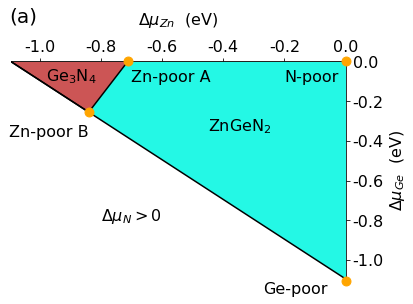

In [40]:
fig = plt.figure(figsize=(6,4))
fig.tight_layout()

ax = plt.subplot(111)

zgn()

plt.savefig('zgn.png', bbox_inches='tight', format='png', dpi=300)


In [59]:
def PlotForm2(Defects1, Condition1, Defects2, Condition2, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure(figsize=(6,6)) 
    ax = plt.subplot(121)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects1:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition1, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects1[i]:
            ax.text(Defects1[i][0],Defects1[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.yaxis.set_ticks_position('both')
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

    
    ax = plt.subplot(122)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects2:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition2, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects2[i]:
            ax.text(Defects2[i][0],Defects2[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    ax.set_yticklabels([], fontsize=16)
    ax.yaxis.set_ticks_position('both')
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    fig.text(0.523, -0.02, 'Fermi Energy (eV)', ha='center', fontsize=16)


Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/3, FormEnth('Ge3N4')/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

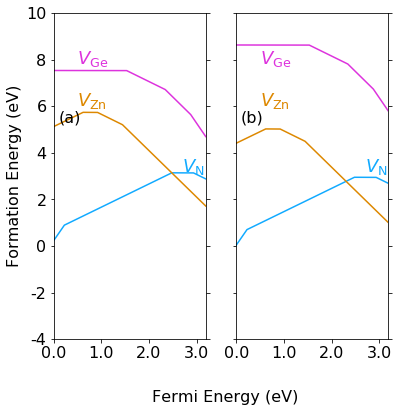

In [66]:
PlotForm2({'V_Ge':[0.5,7.8], 'V_Zn':[0.5,6.0], 'V_N':[2.7,3.2]},Gepoor,
         {'V_Ge':[0.5,7.8], 'V_Zn':[0.5,6.0], 'V_N':[2.7,3.2]},Znpoor1,ylimits=[-4,10])

plt.text(0.1, 5.3, '(b)', fontsize=16)
plt.text(-3.73, 5.3, '(a)', fontsize=16)


plt.savefig('test23.png', bbox_inches='tight', format='png', dpi=300)
plt.savefig('test23.eps', bbox_inches='tight', format='eps', dpi=300)
